# Problem description
In this project we are trying to identify metastatic cancer in digital pathology scans using Convolutional Neural Networks (CNN) to classify the images as having cancer or not.

The dataset has 220,025 square images 96px in size for training. There are 57,458 test images of the same size.  

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf

# Set train and test directories, and set 
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [2]:
print(train_labels.info())

print(train_labels.head())

print(sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None


There are 220,025 samples for the training data. The labels match up to a file in the train directory. The testing data has 57,478 samples. Those labels are found in the testing directory.

# Exploratory Data Analysis

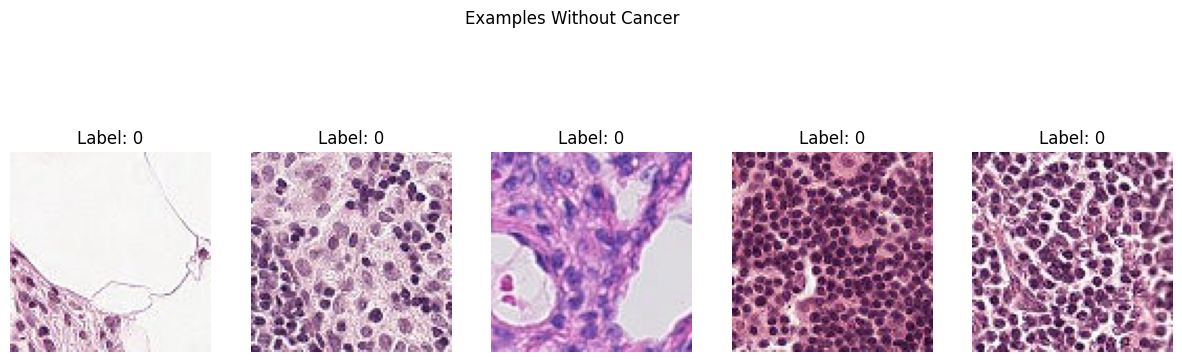

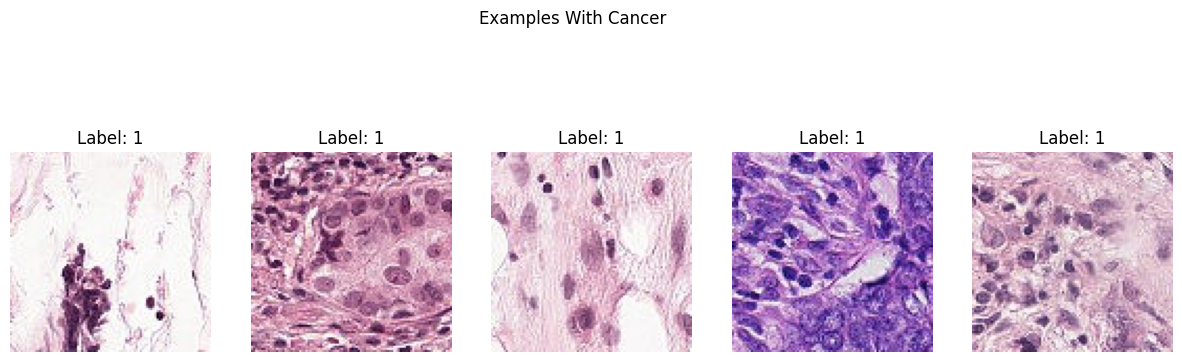

In [3]:
# Visualize some of the images
def show_images(ids, labels, path, title):
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(ids, labels)):
        img_path = os.path.join(path, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(ids), i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Showing 5 examples of images without cancer
show_images(train_labels[train_labels['label'] == 0]['id'][:5], [0]*5, train_dir, "Examples Without Cancer")

# Showing 5 examples of images with cancer
show_images(train_labels[train_labels['label'] == 1]['id'][:5], [1]*5, train_dir, "Examples With Cancer")

In [4]:
# Print the length of the train and test dirs
num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
total_len_of_dataset = num_train_images + num_test_images
print(f"Number of training images: " + str(round(num_train_images / total_len_of_dataset, 2)))
print(f"Number of test images: " + str(round(num_test_images / total_len_of_dataset, 2)))

Number of training images: 0.79
Number of test images: 0.21


Sample image dimensions: (96, 96)
Number of channels in the sample image: RGB




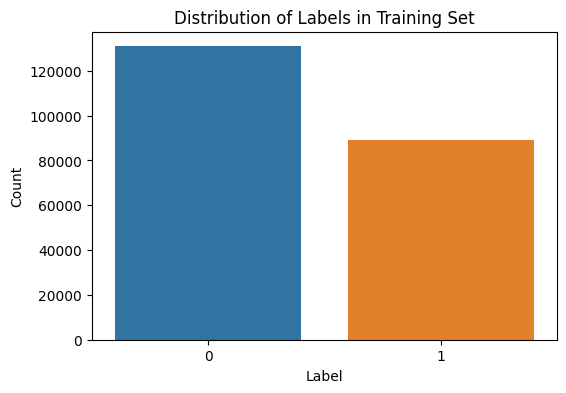

In [5]:
# Print the size of the images and the color channels
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
sample_image = Image.open(sample_image_path)
print(f"Sample image dimensions: {sample_image.size}")
print(f"Number of channels in the sample image: {sample_image.mode}\n\n")

# Print the number of positive and negative samples in the training set
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

This analysis shows that the dataset has an 80/20 split for the testing and training data. The images are 96x96 pixels in size and have RGB channels. Images need to be downscaled to allow for quicker training, and the channels will be normalized from 0-255 to 0-1.

The dataset is decently balanced with a bias towards non-cancerous samples, but the metric for analyzing the performance should not be accuracy due to the imbalance. Recall will be crucial as measuring false negatives is the most important metric.

The training data will need to be formatted properly as it currently has image id's.

The images must be preprocessed to allow for timely training in Kaggle and for the models to be able to train on them.

The following is done to get the images ready for training:
* Normalize color values from 0-255 to 0-1
* Downscale images from 96x96 to 60x60
* Append .tif to the id column so they match the file name in the Kaggle directory
* Modify 'label' column from int64 to string to work with the flow_from_dataframe function
* Will use 25% of the training data for validation to measure overfitting

In [6]:
# Image preprocessing
target_size = (60, 60) # Downscaling
batch_size = 256

train_datagen = ImageDataGenerator(rescale=1./255, # Normalize from 0-255 to 0-1
                                   validation_split=.25
                                  )

# The label must be converted from int64 to string to work with the flow_from_dataframe function
train_labels['label'] = train_labels['label'].astype(str)

# The file id's must have the .tif extension added to work with the flow_from_dataframe function
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

train_data_generator = train_datagen.flow_from_dataframe(dataframe=train_labels,
                                                    directory=train_dir,
                                                    x_col='id',
                                                    y_col='label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    workers=4,
                                                    use_multiprocessing=True,
                                                    subset='training',
                                                    shuffle=True)

validation_data_generator = train_datagen.flow_from_dataframe(dataframe=train_labels,
                                                    directory=train_dir,
                                                    x_col='id',
                                                    y_col='label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    workers=4,
                                                    use_multiprocessing=True,
                                                    subset='validation',
                                                    shuffle=True)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


# Model Architecture

Three models will be tested and compared. 

The first model will have the architecture of:

Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
* Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
* MaxPooling2D(2, 2),

Second convolutional layer with 32 filters
* Conv2D(32, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Third convolutional layer with 64 filters
* Conv2D(64, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

* Flatten(),

Dense layer with dropout for regularization
* Dense(256, activation='relu'),
* Dropout(0.15),

Output layer with a single neuron and sigmoid activation function for binary classification
* Dense(1, activation='sigmoid')

The second model will have the architecture of:

* Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), kernel_regularizer=l2(.0015)),
* Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Flatten(),

* Dense(256, activation='relu', kernel_regularizer=l2(.0015)),
* Dropout(0.4),
* Dense(1, activation='sigmoid')

Third model architecture:

Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
* Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
* Conv2D(16, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Second convolutional layer with 32 filters
* Conv2D(32, (3, 3), activation='relu'),
* Conv2D(32, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Third convolutional layer with 64 filters
* Conv2D(64, (3, 3), activation='relu'),
* Conv2D(64, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

* Flatten(),

Dense layer with dropout for regularization
* Dense(256, activation='relu'),
* Dropout(0.25),

Output layer with a single neuron and sigmoid activation function for binary classification
* Dense(1, activation='sigmoid')


The first model is quite simple with single convolutional layers that increasingly increase in filter size. The dense layer has a small dropout afterwards to help with overfitting, but it's not much since the model is simple. 

The second model is a much more powerful (on paper) model that has convolutional layers back to back with double the filter sizes as the first model. It also has l2 regularization and more dropouts. The idea is since this is so complex, it needs more regularization to help prevent overfitting. 

The third model is a mix of the first and second modal, with 2 convolution layers back to back before pooling, and a slightly increased dropout.

All models have early stopping enabled if the model doesn't improve. The second model also implements learning rate reduction when the validation loss plateaus.

# Results and Analysis

In [13]:
# First model architecture
model = Sequential([
    # Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2, 2),
    # Second convolutional layer with 32 filters
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    # Dense layer with dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.15),
    # Output layer with a single neuron and sigmoid activation function for binary classification
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 5, 5, 64)         

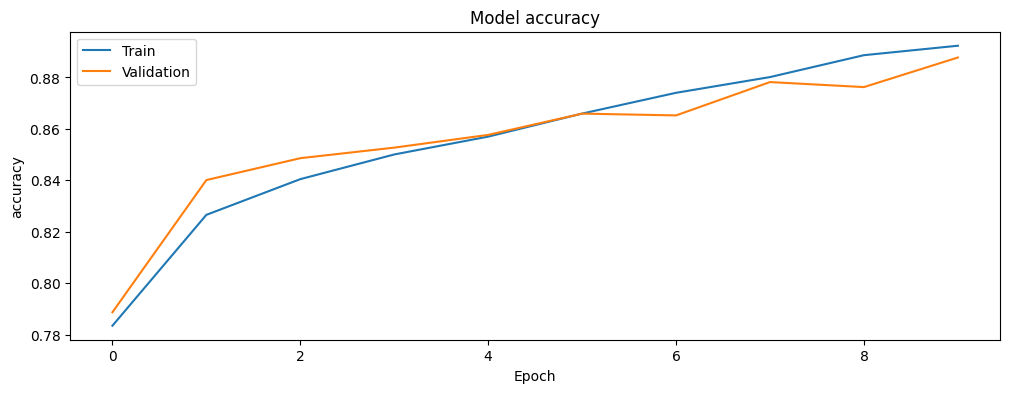

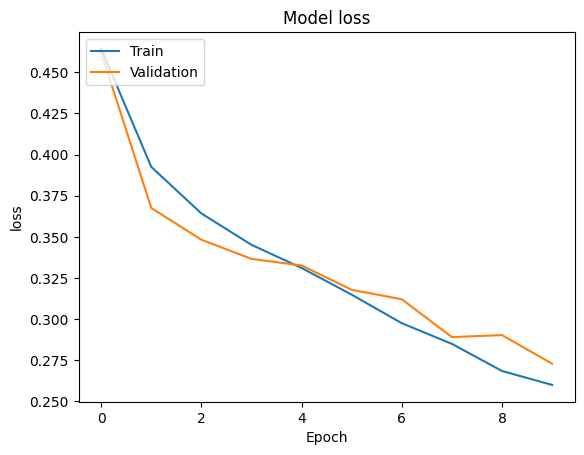

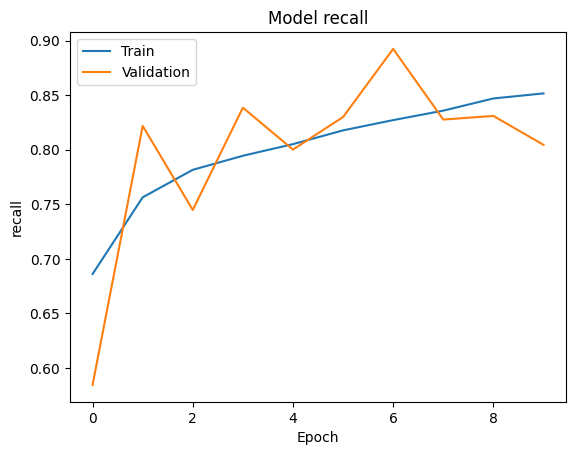

In [14]:
def plot_metric(history, metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'recall')

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Second model architecture
second_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), kernel_regularizer=l2(.0015)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(.0015)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

second_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

second_model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

# Training the model
history = second_model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 56, 56, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)       

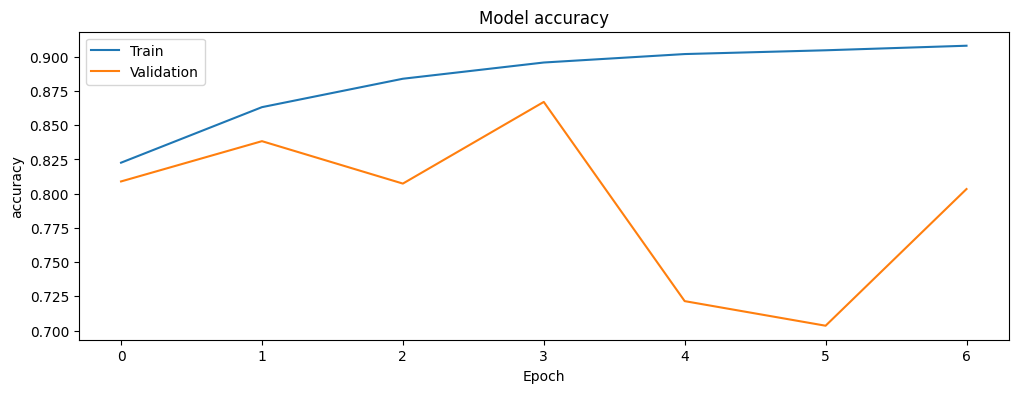

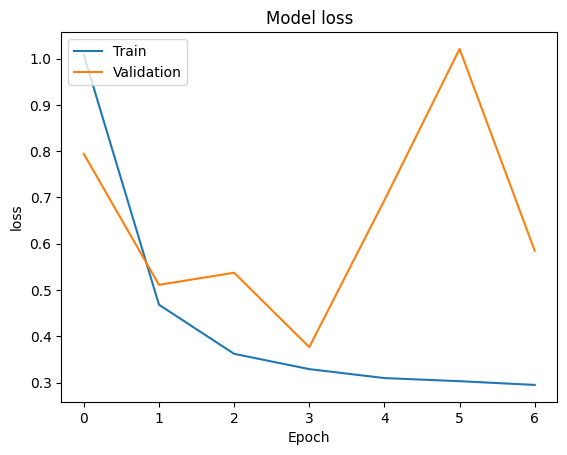

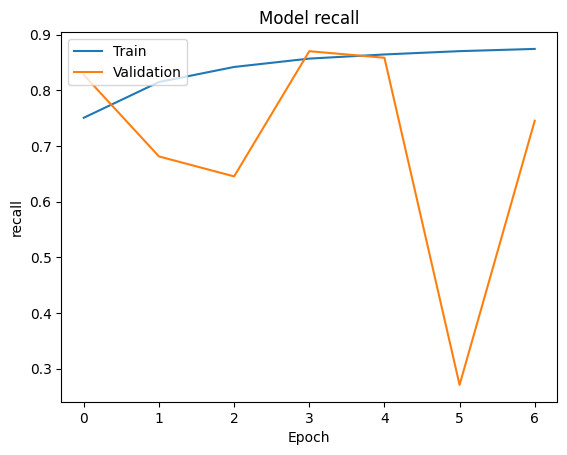

In [10]:
plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'recall')

In [7]:
# First model architecture
third_model = Sequential([
    # Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Second convolutional layer with 32 filters
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    # Dense layer with dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.25),
    # Output layer with a single neuron and sigmoid activation function for binary classification
    Dense(1, activation='sigmoid')
])

third_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

third_model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = third_model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                   

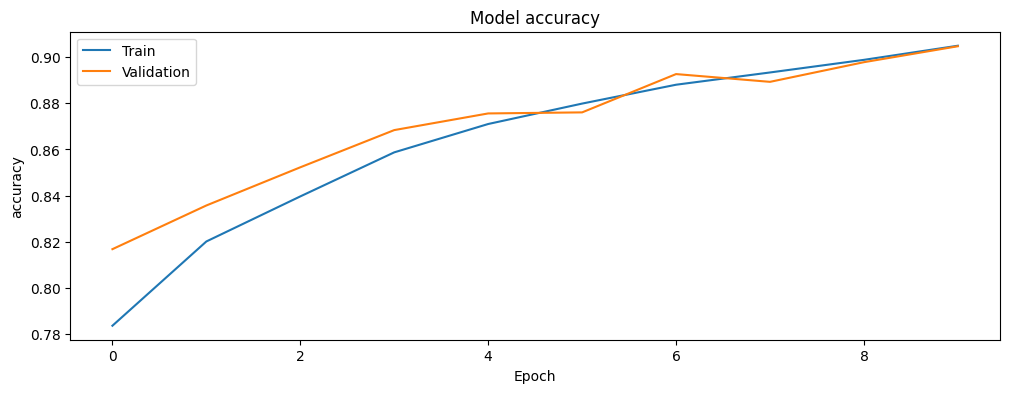

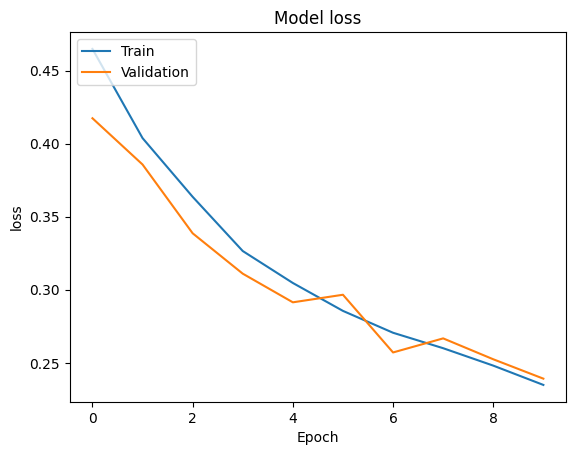

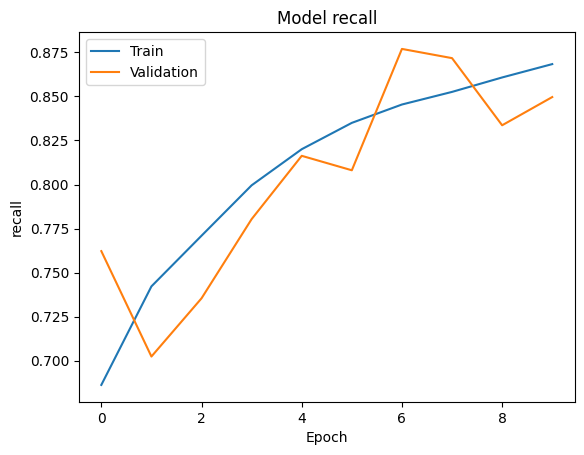

In [8]:
plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'recall')

## Model Results

### Model 1 Results
Model 1 finished training with the following metrics:
loss: 0.2600 - accuracy: 0.8923 - recall: 0.8516 - val_loss: 0.2729 - val_accuracy: 0.8877 - val_recall: 0.8045

The training data resulted in a loss of 26.12%, an accuracy of 89.38%, and recall of 85%. The validation data (25% of the dataset) has a loss of 27.97%, an accuracy of 88.6%, and a recall of 85.49%. These are quite good results and the metrics are close for both the training and validation data, suggesting that the model didn't start to overfit. An accuracy of 88-89% is quite good for what is supposed to be the more basic model.

### Model 2 Results
Model 2 finished training with the following metrics:
loss: 0.2949 - accuracy: 0.9080 - recall: 0.8743 - val_loss: 0.5848 - val_accuracy: 0.8034 - val_recall: 0.7454 - lr: 0.0010

### Model 3 Results
Model 3 finished training with the following metrics:
loss: 0.2349 - accuracy: 0.9049 - recall: 0.8683 - val_loss: 0.2392 - val_accuracy: 0.9047 - val_recall: 0.8496

Model 2 slightly edges out model 3 with the best performance, but it has much worse validation data scores. Model 3 is by far the winner when taking the validation data into consideration. I tried lots of experimentation with Model 2 but I was not able to find a good combination of lots of convolution layers with regularization since it took hours to test out a single model run. I like the basic nature of models 1 and 3 that outperform model 2 and are far simpler.

## Submission Results

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255, # Normalize from 0-255 to 0-1
                                  )

test_files = os.listdir(test_dir)
test_dataframe = pd.DataFrame(test_files, columns=['id'])
test_data_generator = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                                    directory=test_dir,
                                                    x_col='id',
                                                    y_col=None,
                                                    target_size=target_size,
                                                    class_mode=None,
                                                    workers=4,
                                                    use_multiprocessing=True)

Found 57458 validated image filenames.


In [16]:
predictions = third_model.predict(test_data_generator)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_dataframe)}")
binary_predictions = (predictions >= 0.5).astype(int).flatten() # convert the sigmoid 0-1 to either 0 or 1
print(len(binary_predictions))
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_dataframe['id'].apply(lambda x: x.split('.')[0]) # remove .tif from the id
submission_dataframe['label'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

1796/1796 [==============================] - 175s 98ms/step
Number of predictions: 57458
Number of test samples: 57458
57458



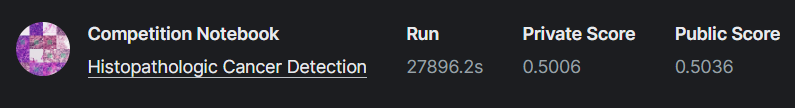

I spent a lot of time trying different model combinations within the constraints of Kaggle notebooks which are not setup well to run these kind of models. I wasn't able to achieve much past .50xx score even with lots of alterations unfortunately.

# Conclusion

Throughout this project I tried so many tweaks to the model architecture like the filter size, batch normalization, dropout, and dense layers to little affect on the submission score. What ultimately ended up being successful was keeping the model simple and lightweight with some dropout to help with overfitting. Even then, it still only led to the score of .50xx. If I was doing this professionally, having GPU's to decrease the training time substantially would be really helpful to test out small tweaks. 

One exploration that I'd look into more if I was aiming for maximum score is integrating in a pre-trained CNN off of ResNet or another dataset. This is what other Kaggle notebooks for this project are using to achieve high scores. 